# Monte Carlo simulator
By: Magnus Kvåle Helliesen

# *** *Under construction* ***

In [122]:
import pandas as pd
import numpy as np
from numpy.linalg import eig, inv
import matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model

Suppose we have a matrix of data $\bm{X}=(\bm{x}_0, \bm{x}_1, \ldots, \bm{x}_{N-1})$, where $\bm{x}_i=\{x_{i, t}\}_{t=0}^{T-1}$ is a vector representing the timeseries for some $i$ (maybe a stock ticker or something).

The aim of this notebook is to use eigen decomposition to generate $N$ independent/orthogonal disturbances, normalize these using a GARCH-model (so there is no heteroskedasticity), and draw from the resulting distributions to perform a MonteCarlo-like simulation of the input data.

In [123]:
# Class to be built
class MonteCarlo():
    def __init__(self, df: pd.DataFrame):
        self._df = df

    @property
    def df(self):
        return self._df

    def fit(self):
        # Deep copying DataFrame and calculating covariance matrix
        df_orthongonal_disturbances = self.df.copy(deep=True)
        array = df_orthongonal_disturbances.to_numpy()
        covariance_matrix = np.cov(array.T)

        # Calculating eigenvalues and vectors from covariance matrix
        eigen_values, eigen_vectors = eig(covariance_matrix)
        eigen_values = np.diag(eigen_values)
        
        # Calculating weights and orthogonal disturbances with unit variance
        combination_matrix = (eigen_values**0.5).dot(eigen_vectors.T)
        array[:, :] = array.dot(inv(combination_matrix))

        # Renaming columns
        df_orthongonal_disturbances.columns = [i for i in range(len(df_orthongonal_disturbances.columns))]

        # Setting up GARCH-model for each orthogonal disturbance
        garch_models = {i: arch_model(df_orthongonal_disturbances[i], vol='garch', p=1, o=0, q=1, rescale=False)
                  for i in df_orthongonal_disturbances.columns}

        # Calculating model fits
        garch_fits = {i: model.fit(disp='off') for i, model in garch_models.items()}

        # Calcutating conditional volatility
        df_conditional_volatility = pd.DataFrame()
        for i in range(len(df_orthongonal_disturbances.columns)):
            df_conditional_volatility[i] = garch_fits[i].conditional_volatility

        # calculating orthogonal disturbances normalized by GARCH standard deviation
        df_normalized_orthogonal_disturbances = df_orthongonal_disturbances/df_conditional_volatility

        # Not sure this is the way to go
        self._scaling_matrix = combination_matrix
        self._df_orthogonal_disturbances = df_orthongonal_disturbances
        self._df_normalized_orthogonal_disturbances = df_normalized_orthogonal_disturbances
        self._garch_models = garch_models
        self._garch_fits = garch_fits

        # Returning MonteCarloFit object
        return MonteCarloFit(self)

# Class to be built
class MonteCarloFit():
    def __init__(self, MonteCarlo: MonteCarlo):
        self._MonteCarlo = MonteCarlo

    @property
    def scaling_matrix(self):
        return self._MonteCarlo._scaling_matrix

    @property
    def df_orthogonal_disturbances(self):
        return self._MonteCarlo._df_orthogonal_disturbances

    @property
    def df_normalized_orthogonal_disturbances(self):
        return self._MonteCarlo._df_normalized_orthogonal_disturbances


# Use MonteCarlo class

In [124]:
# Function that fetches data
def fetch_data(tickers: tuple):
    data = {}
    for ticker in tickers:
        data[ticker] = yf.Ticker(ticker).history(period='max')

    # Returning transformed data
    return (
        pd.concat(data)[['Close']]
        .reset_index()
        .rename(columns={'level_0': 'Ticker'})
        .pivot(index='Date', columns='Ticker', values='Close')
    )

tickers = ('NHY.OL', 'DNB.OL', 'YAR.OL', 'NAS.OL', 'TEL.OL', 'FRO.OL')
df_orthongonal_disturbances = fetch_data(tickers).dropna()
df_orthongonal_disturbances

Ticker,DNB.OL,NAS.OL,NHY.OL,TEL.OL,YAR.OL
Date,,,,,
2004-03-25 00:00:00+01:00,17.060755,1216.948120,10.377870,18.962240,22.093437
2004-03-26 00:00:00+01:00,17.216923,1199.807983,10.389773,19.238768,22.526642
2004-03-29 00:00:00+02:00,17.255962,1216.948120,10.330267,19.712828,21.985134
2004-03-30 00:00:00+02:00,17.177883,1222.661499,10.246955,18.646200,21.660231
2004-03-31 00:00:00+02:00,17.568287,1199.807983,10.282660,18.804216,21.573584
...,...,...,...,...,...
2023-10-23 00:00:00+02:00,206.000000,7.884000,56.759998,114.199997,361.399994
2023-10-24 00:00:00+02:00,203.899994,8.172000,59.680000,113.400002,361.700012
2023-10-25 00:00:00+02:00,200.000000,7.880000,59.939999,115.949997,360.200012


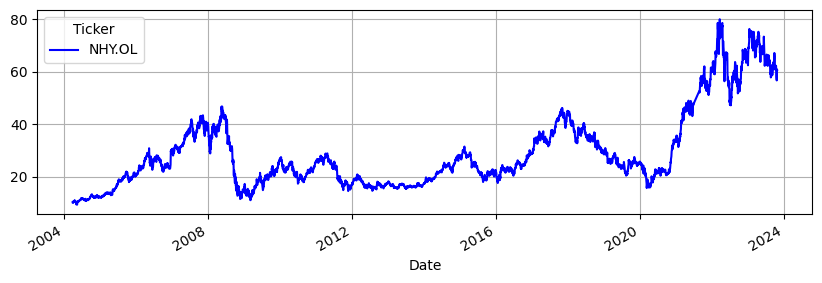

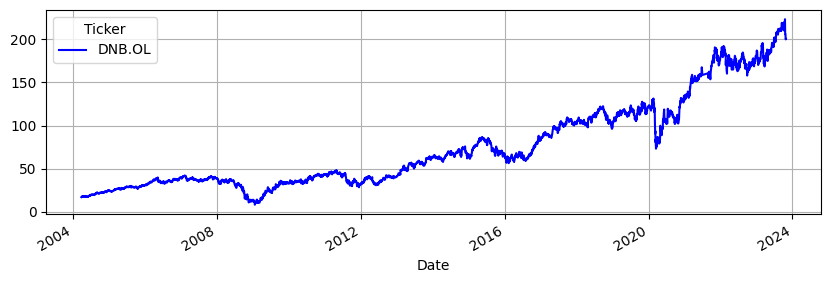

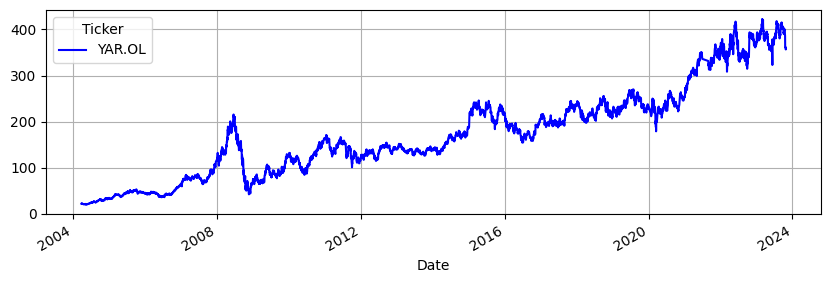

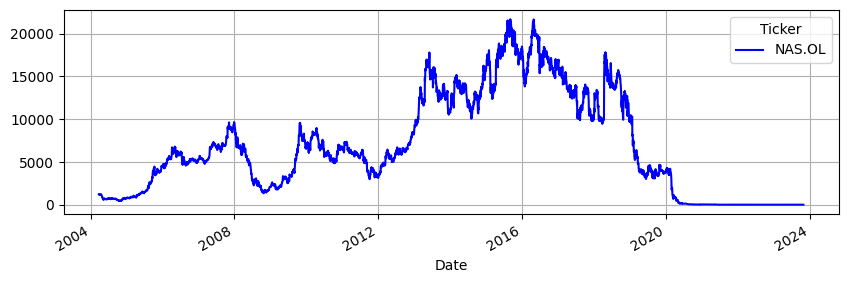

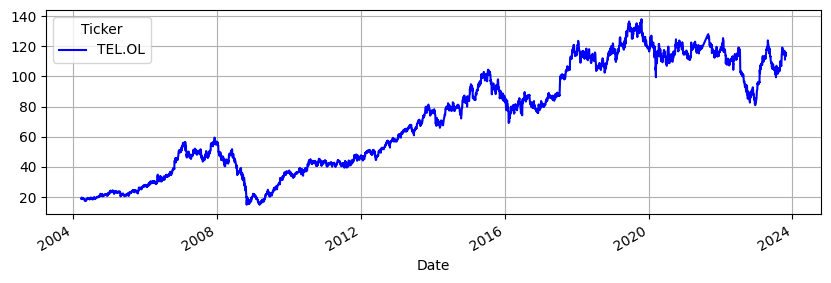

In [125]:
for ticker in tickers:
    df_orthongonal_disturbances[[ticker]].plot(color='b', figsize=(10, 3), grid=True)

In [126]:
# Calculating log-differences and removing first value
df_diff = np.log(df_orthongonal_disturbances).diff().iloc[1:, :]
df_diff

Ticker,DNB.OL,NAS.OL,NHY.OL,TEL.OL,YAR.OL
Date,,,,,
2004-03-26 00:00:00+01:00,0.009112,-0.014185,0.001146,0.014478,0.019418
2004-03-29 00:00:00+02:00,0.002265,0.014185,-0.005744,0.024342,-0.024332
2004-03-30 00:00:00+02:00,-0.004535,0.004684,-0.008098,-0.055627,-0.014889
2004-03-31 00:00:00+02:00,0.022473,-0.018869,0.003478,0.008439,-0.004008
2004-04-01 00:00:00+02:00,-0.011173,-0.014389,-0.005804,-0.004210,0.004008
...,...,...,...,...,...
2023-10-23 00:00:00+02:00,0.000000,-0.004556,-0.021956,-0.013481,-0.000553
2023-10-24 00:00:00+02:00,-0.010247,0.035878,0.050165,-0.007030,0.000830
2023-10-25 00:00:00+02:00,-0.019312,-0.036386,0.004347,0.022238,-0.004156


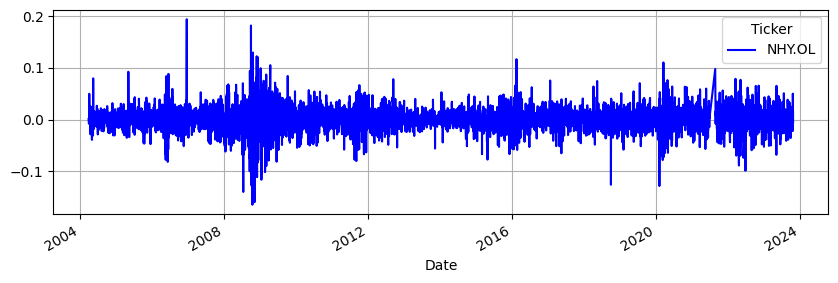

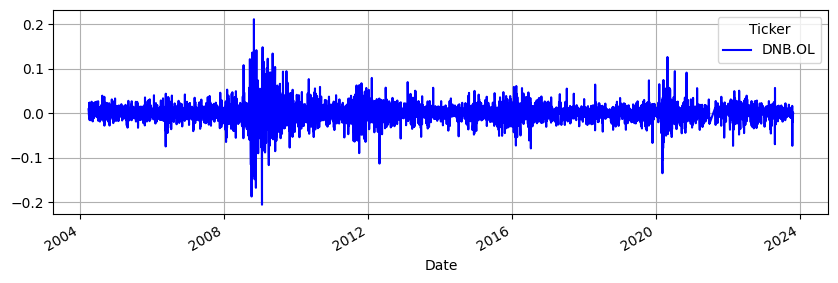

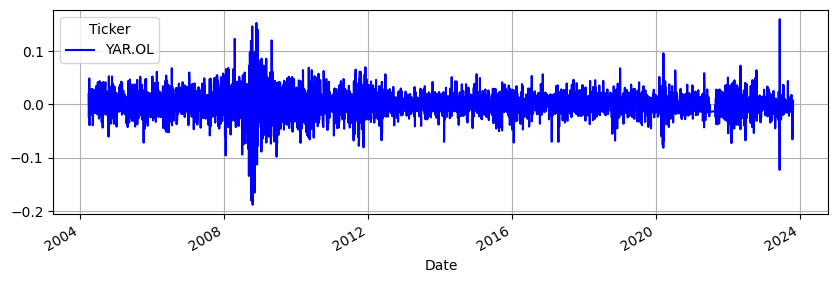

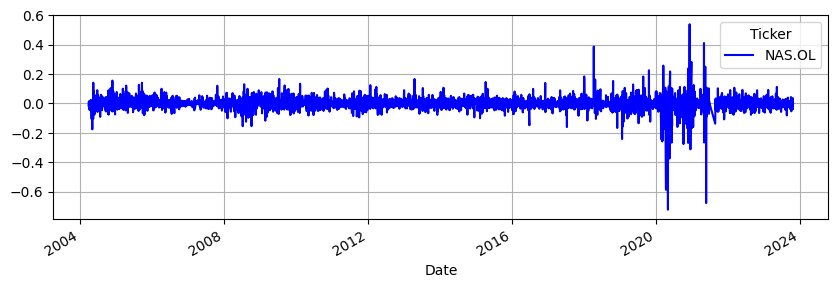

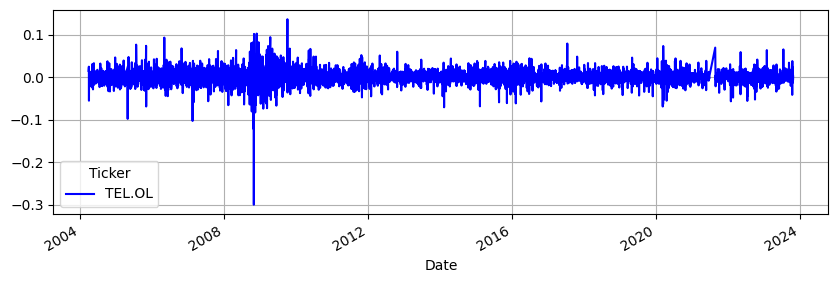

In [127]:
for ticker in tickers:
    df_diff[[ticker]].plot(color='b', figsize=(10, 3), grid=True)

In [128]:
df_diff.corr().style.background_gradient(cmap='Blues')

Ticker,DNB.OL,NAS.OL,NHY.OL,TEL.OL,YAR.OL
Ticker,,,,,
DNB.OL,1.000000,0.194920,0.482605,0.388664,0.418182
NAS.OL,0.194920,1.000000,0.204137,0.152877,0.167200
NHY.OL,0.482605,0.204137,1.000000,0.353360,0.487499
TEL.OL,0.388664,0.152877,0.353360,1.000000,0.346859
YAR.OL,0.418182,0.167200,0.487499,0.346859,1.000000


In [129]:
model = MonteCarlo(df_diff)
fit = model.fit()

# Okay, the disturbances are orthogonal. This we can work with
fit.df_orthogonal_disturbances.cov().style.background_gradient(cmap='Blues')

,0,1,2,3,4
0,1.000000,0.000000,0.000000,-0.000000,0.000000
1,0.000000,1.000000,-0.000000,0.000000,0.000000
2,0.000000,-0.000000,1.000000,-0.000000,-0.000000
3,-0.000000,0.000000,-0.000000,1.000000,0.000000
4,0.000000,0.000000,-0.000000,0.000000,1.000000


In [132]:
# The normalized ones are nearly orthogonal too
fit.df_normalized_orthogonal_disturbances.cov().style.background_gradient(cmap='Blues')

,0,1,2,3,4
0,0.999379,-0.032763,-0.018403,0.007189,-0.010717
1,-0.032763,0.999706,0.026220,-0.056186,0.027319
2,-0.018403,0.026220,1.000845,0.009662,-0.031484
3,0.007189,-0.056186,0.009662,1.000760,0.068018
4,-0.010717,0.027319,-0.031484,0.068018,1.000483


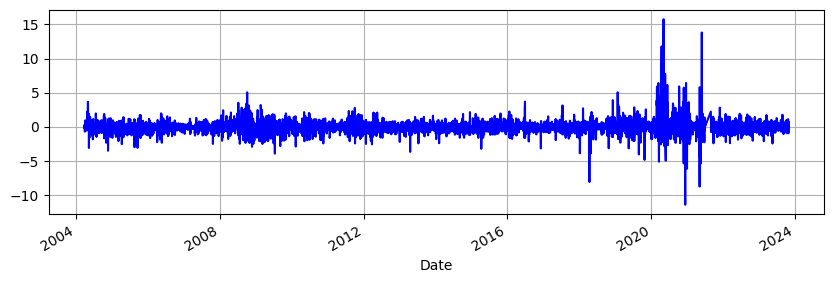

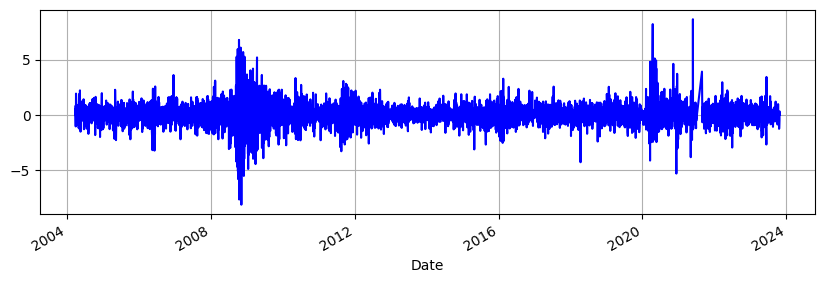

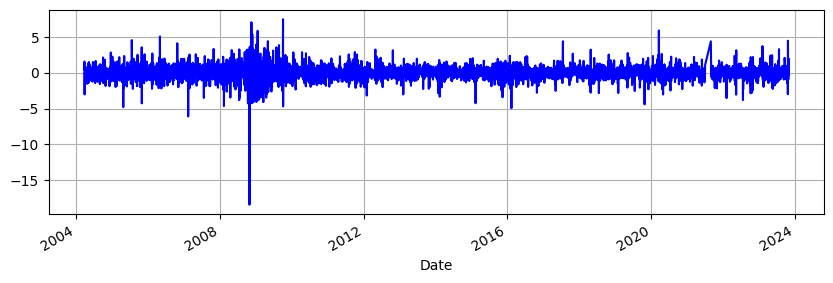

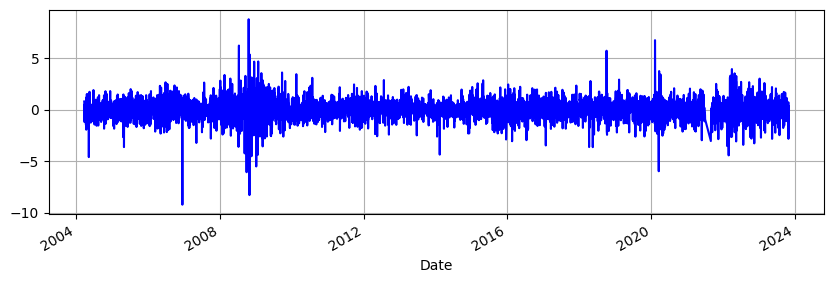

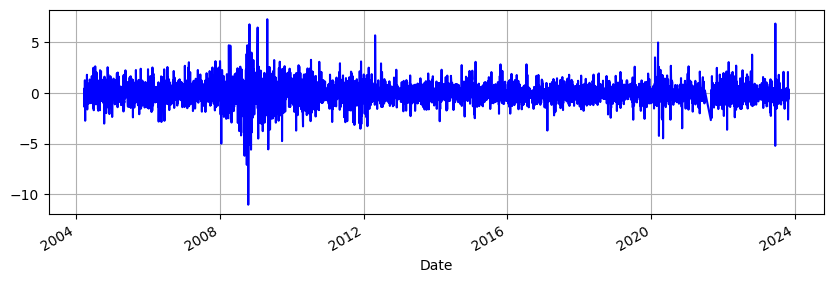

In [130]:
# Orthogonal disturbances
for i in range(len(fit.df_orthogonal_disturbances.columns)):
    plt.figure()
    fit.df_orthogonal_disturbances[i].plot(color='b', figsize=(10, 3), grid=True)
    plt.draw()

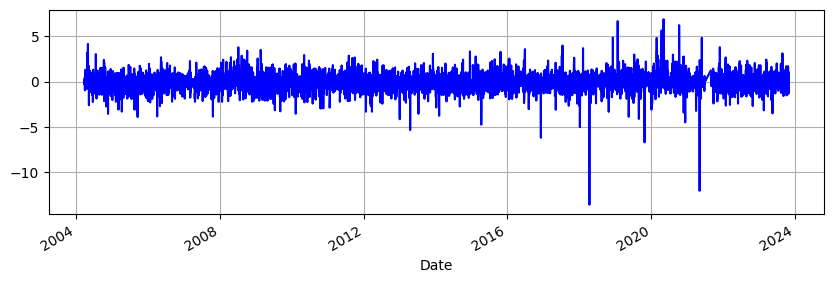

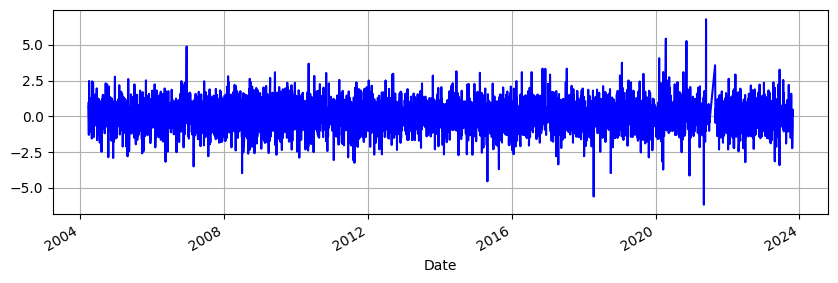

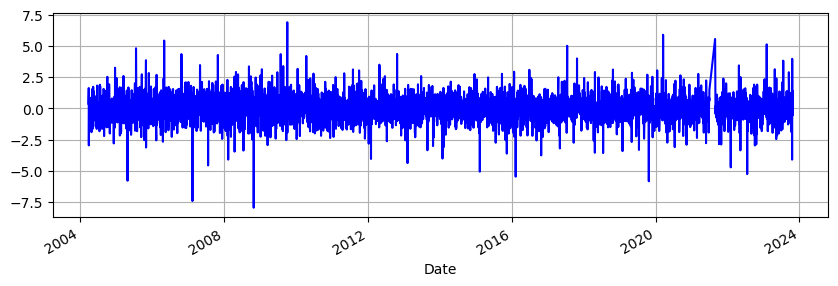

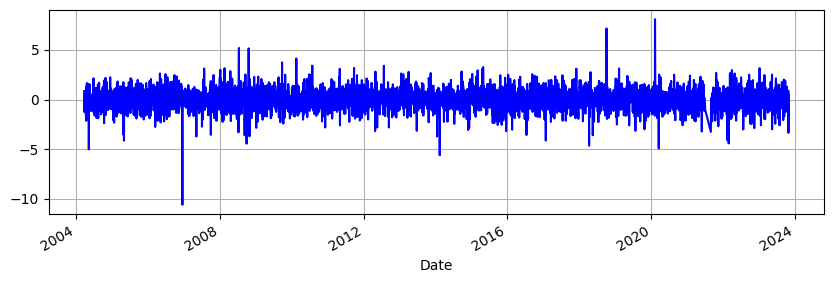

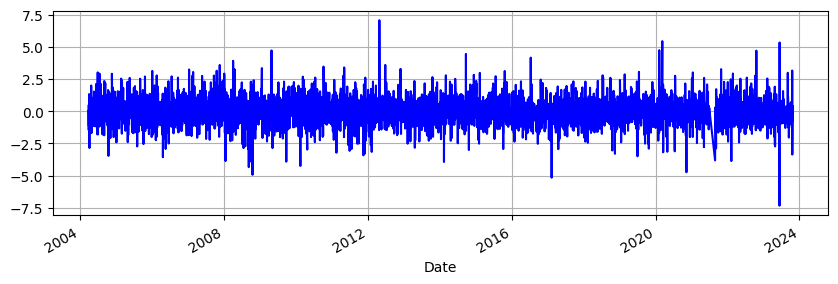

In [131]:
# Orthognal disturbances where heteroskedasticity is removed using GARCH model fits
for i in range(len(fit.df_orthogonal_disturbances.columns)):
    plt.figure()
    fit.df_normalized_orthogonal_disturbances[i].plot(color='b', figsize=(10, 3), grid=True)
    plt.draw()